In [150]:
#import pandas as pd
#data = pd.read_csv(f"datasets/pathways.csv", low_memory=False).set_index("run")
#data_filtered = data[data["bioProject"] == "PRJNA895487"]
#data_filtered.to_csv("datasets/pathways-PRJNA895487.csv")
#data_filtered.head()

#bioProject
#PRJNA895487    138
#PRJNA516054     70
#PRJNA451479     54
#PRJEB23052      50
#PRJNA782533     38
#PRJNA845014     36
#PRJNA530620     15
#PRJNA686821     15

In [151]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import IsolationForest

In [152]:
# Cleaning
samples_threshold = 0.90
feature_threshold = 0.80

# File and model
controls = False
file = "enzymes"
model_type = f"General-{file}"
output_excel = f"{file}-predictions-{model_type}"

In [153]:
def pie_charts(dataset):

    import matplotlib.pyplot as plt
    # Ensure the output directory exists
    # Pie chart - diagnosis
    diagnosis = dataset["diagnosis"].value_counts()
    diagnosis.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='tab20b')
    plt.title('Diagnosis Distribution')
    plt.ylabel('')

    #plt.tight_layout()
    plt.savefig(f"diagnosis-distribution.png", dpi=350)
    plt.show()
    
def nan2zero(dataset):
    numeric_columns = dataset.select_dtypes(include=['number']).columns
    dataset[numeric_columns] = dataset[numeric_columns].fillna(0)
    dataset = dataset.fillna("Unknown")
    return dataset

def run_permanova(dataset, feature, to_drop):
    import pandas as pd
    from scipy.spatial.distance import pdist, squareform
    from skbio.stats.distance import DistanceMatrix
    from skbio.stats.distance import permanova

    # Step 1: Prepare data
    permanova_df = dataset.copy()
    permanova_df = nan2zero(permanova_df)
    permanova_df.columns = permanova_df.columns.astype(str)

    if feature in to_drop:
        to_drop = [col for col in to_drop if col != feature]

    permanova_df = permanova_df.drop(columns=[col for col in to_drop if col in permanova_df.columns], errors='ignore')
    
    if feature not in permanova_df.columns:
        print(f"\nFeature '{feature}' not found after dropping columns. Skipping PERMANOVA for this feature.")
        return None, None
    
    permanova_df = permanova_df.dropna(subset=[feature])
    
    # Step 2: Factorize the grouping variable
    permanova_df['labels'], _ = pd.factorize(permanova_df[feature])
    permanova_df = permanova_df.drop(columns=[feature])

    # Step 3: Independent variables and DistanceMatrix
    independent_variables = permanova_df.drop(columns=['labels']).astype(float)
    ids = independent_variables.index.astype(str)
    distance_matrix = squareform(pdist(independent_variables, metric='euclidean'))
    distance_matrix_object = DistanceMatrix(distance_matrix, ids=ids)

    # Step 4: Ensure grouping has matching index (string type)
    grouping_values = permanova_df.loc[independent_variables.index, 'labels'].values
    grouping = pd.Series(grouping_values, index=ids, name='labels')

    # Step 5: Run PERMANOVA
    result = permanova(distance_matrix_object, grouping=grouping)

    print(f"PERMANOVA results for {feature}:")
    print("F-statistic:", result['test statistic'])
    print("p-value:", result['p-value'])

    return str(result['p-value']), str(result['test statistic'])

def pls_variance_explained(data, factor_variable, to_drop):
    import numpy as np
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.cross_decomposition import PLSRegression
    import pandas as pd

    print(f"Calculating explained variability for factor: '{factor_variable}'...")

    # Prepare response variables (exclude metadata, including factor_variable itself)
    to_drop_extended = to_drop + [factor_variable]
    data = nan2zero(data)
    response_variables = data.drop(columns=to_drop_extended, errors='ignore').select_dtypes(include=[np.number]).columns.tolist()

    if not response_variables:
        raise ValueError("No numeric response variables found after excluding metadata.")

    Y = data[response_variables].values

    # Prepare predictor X (diagnosis/factor_variable)
    X = data[[factor_variable]].astype(str)
    
    # Optional: replace TD/ASD with 0/1 if desired
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    X_encoded = le.fit_transform(X[factor_variable]).reshape(-1, 1)

    # Scale Y
    scaler = StandardScaler()
    Y_scaled = scaler.fit_transform(Y)

    # PLS regression
    n_components = min(X_encoded.shape[1], Y.shape[1], 2)
    pls = PLSRegression(n_components=n_components, max_iter=10000)
    pls.fit(X_encoded, Y_scaled)
    Y_pred = pls.predict(X_encoded)

    # Variance explained
    total_variance_Y = np.sum(np.var(Y_scaled, axis=0, ddof=1))
    explained_variance = np.sum(np.var(Y_pred, axis=0, ddof=1))
    percentage_explained = (explained_variance / total_variance_Y) * 100

    print(f"Percentage of variance explained by '{factor_variable}': {percentage_explained:.2f}%")
    return percentage_explained

def merge_dataframes(df1, df2):
    import pandas as pd
    # Concatenate the dataframes along the index
    merged_df = pd.concat([df1, df2], axis=0)
    # Group by the index and aggregate the values
    merged_df = merged_df.groupby(merged_df.index).first()
    return merged_df

def model_performance(y_test, y_pred, y_prob):
    import pandas as pd
    from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, 
                                 roc_curve, accuracy_score, precision_score, recall_score, f1_score)
    import matplotlib.pyplot as plt
    import numpy as np

    # Binary encoding
    label_map = {'TD': 0, 'ASD': 1}
    y_test_bin = pd.Series(y_test).map(label_map).astype(int)
    y_pred_bin = pd.Series(y_pred).map(label_map).astype(int)

    print("Label encoding: TD -> 0, ASD -> 1")

    # AUC and ROC
    if len(np.unique(y_test_bin)) == 2:
        auc_score = roc_auc_score(y_test_bin, y_prob)

        fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
    else:
        print("AUC calculation for multiclass requires additional parameters.")
        auc_score = None

    # Confusion matrix
    cm = confusion_matrix(y_test_bin, y_pred_bin, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["TD", "ASD"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

    # Classification metrics
    accuracy = accuracy_score(y_test_bin, y_pred_bin)
    precision = precision_score(y_test_bin, y_pred_bin, pos_label=1)
    recall = recall_score(y_test_bin, y_pred_bin, pos_label=1)
    f1 = f1_score(y_test_bin, y_pred_bin, pos_label=1)

    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (tp + fn)

    print(f"AUC: {auc_score:.2f}" if auc_score else "AUC: Not applicable")
    print(f"Accuracy : {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall   : {recall:.2f}")
    print(f"F1 Score : {f1:.2f}")
    print(f"True Positive : {tp}")
    print(f"True Negative : {tn}")
    print(f"False Positive Rate: {fpr:.2f}")
    print(f"False Negative Rate: {fnr:.2f}")

    return auc_score, accuracy, precision, recall, f1, tn, tp, fn, fp, fpr, fnr



In [154]:
def samples_selection(df, threshold):
    print(f"Samples with more than {threshold*100} percentage of zero values will be removed.")
    # Define the threshold for zero values in a row (90%)
    threshold = threshold
    # Calculate the percentage of zeros in each row
    zero_percentage = (df == 0).mean(axis=1)
    # Filter out rows with more than 90% zeros
    df = df[zero_percentage < threshold]
    return df

def data_cleaning_step(data, metadata, samples_threshold, feature_threshold):

    cleaned_data = data.copy()
    #target = cleaned_data["diagnosis"]
    
    cleaned_data = samples_selection(cleaned_data, samples_threshold) # Percentage of samples to drop
    cleaned_data = feature_selection(cleaned_data, feature_threshold, metadata) # Percentage of features to drop

    print("\nDataframes shapes:")
    print("Raw data: ", data.shape)
    print("Cleaned data: ", cleaned_data.shape)
    return cleaned_data

def feature_selection(dataset, threshold, metadata):
    print(f"Features with more than {threshold*100} percentage of zero values will be removed.")
    # Replacing negative values with 0
    print("Replacing NaN and negative values with 0.0 ...")
    numeric_columns = dataset.select_dtypes(include=['number']).columns
    dataset[numeric_columns] = dataset[numeric_columns].fillna(0).clip(lower=0)
    columns_with_nan = dataset.columns[dataset.isna().any()].tolist()
 
    try:
        for element in columns_with_nan:
            if element not in metadata:
                 dataset[element] = dataset[element].fillna(0)
    except:pass
    
    columns_to_drop = dataset.columns[(dataset == 0).mean() > threshold]
    dataset = dataset.drop(columns=columns_to_drop)
    columns_with_nan = dataset.columns[dataset.isna().any()].tolist()
    # Eliminating columns with zero values only.
    dataset = dataset.loc[:, (dataset != 0).any(axis=0)]
    return dataset


Samples with more than 90.0 percentage of zero values will be removed.
Features with more than 80.0 percentage of zero values will be removed.
Replacing NaN and negative values with 0.0 ...

Dataframes shapes:
Raw data:  (416, 393730)
Cleaned data:  (416, 68564)


bioProject locationCountry locationContinent diagnosis  \
run                                                                  
ERR2608606  PRJEB23052           China              Asia        TD   
ERR2608607  PRJEB23052           China              Asia        TD   
ERR2608608  PRJEB23052           China              Asia        TD   
ERR2608609  PRJEB23052           China              Asia        TD   
ERR2608610  PRJEB23052           China              Asia        TD   

                     instrument  LIMONENE-6-@MONOOXYGENASE-@RXN  \
run                                                               
ERR2608606  Illumina HiSeq 4000                          3.0700   
ERR2608607  Illumina HiSeq 4000                          0.0855   
ERR2608608  Illumina HiSeq 4000                          0.3360   
ERR2608609  Illumina HiSeq 4000                          0.0765   
ERR2608610  Illumina HiSeq 4000                          0.0525   

            --LIMONENE-6-MONOOXYGENASE-RXN|g__Escherichia.s__Escherichia_coli  \
run                                                                             
ERR2608606                                             2.3000                   
ERR2608607                                             0.0000                   
ERR2608608                                             0.0747                   
ERR2608609                                             0.0000                   
ERR2608610                                             0.0000                   

            --LIMONENE-6-MONOOXYGENASE-RXN|unclassified  \
run                                                       
ERR2608606                                       0.1000   
ERR2608607                                       0.0855   
ERR2608608                                       0.1130   
ERR2608609                                       0.0765   
ERR2608610                                       0.0525   

            1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN  \
run                                               
ERR2608606                             0.000693   
ERR2608607                             0.001651   
ERR2608608                             0.000626   
ERR2608609                             0.000934   
ERR2608610                             0.001064   

            1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN|g__Alistipes.s__Alistipes_finegoldii  \
run                                                                                    
ERR2608606                                                0.0                          
ERR2608607                                                0.0                          
ERR2608608                                                0.0                          
ERR2608609                                                0.0                          
ERR2608610                                                0.0                          

            ...  \
run         ...   
ERR2608606  ...   
ERR2608607  ...   
ERR2608608  ...   
ERR2608609  ...   
ERR2608610  ...   

            XYLULOKIN-RXN|g__Lachnospiraceae_unclassified.s__Eubacterium_rectale  \
run                                                                                
ERR2608606                                                0.0                      
ERR2608607                                                0.0                      
ERR2608608                                                0.0                      
ERR2608609                                                0.0                      
ERR2608610                                                0.0                      

            XYLULOKIN-RXN|g__Roseburia.s__Roseburia_faecis  \
run                                                          
ERR2608606                                           0.531   
ERR2608607                                           0.000   
ERR2608608                                           0.000   
ERR2608609                                           0.203   

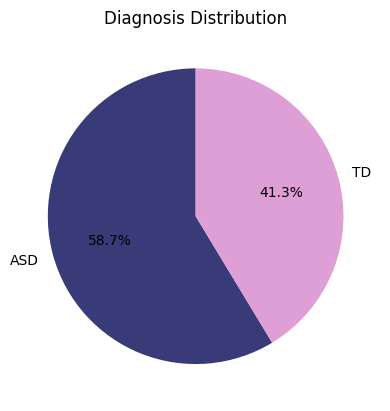

In [155]:
import pandas as pd

if controls == False:
    data = pd.read_csv(f"datasets/{file}.csv", low_memory=False).set_index("run")
else: data = pd.read_csv(f"controls/{file}.csv", low_memory=False).set_index("run")

metadata = ["locationCountry", "locationContinent", "instrument", "bioProject"]
if controls == False:
    index_names = data[ (data['diagnosis'] != "TD") & (data['diagnosis'] != 'ASD')].index
    data.drop(index_names, inplace = True)

try:
    data = pd.read_csv(f"datasets/{file}-clean.csv", low_memory=False).set_index("run")
    print("Dataset has already been cleaned.")
    try: data = data.drop(columns=["Unnamed: 0"])
    except:pass
except: 
    data = data_cleaning_step(data, metadata, samples_threshold, feature_threshold)
    data.to_csv(f"datasets/{file}-clean.csv")

display(data.head())
pie_charts(data)


In [156]:
print(data.value_counts("bioProject"))

bioProject
PRJNA895487    138
PRJNA516054     70
PRJNA451479     54
PRJEB23052      50
PRJNA782533     38
PRJNA845014     36
PRJNA530620     15
PRJNA686821     15
Name: count, dtype: int64


In [157]:
data.describe()

LIMONENE-6-@MONOOXYGENASE-@RXN  \
count                      416.000000   
mean                         0.172654   
std                          0.635863   
min                          0.000000   
25%                          0.000000   
50%                          0.000000   
75%                          0.000000   
max                          7.520000   

       --LIMONENE-6-MONOOXYGENASE-RXN|g__Escherichia.s__Escherichia_coli  \
count                                       4.160000e+02                   
mean                                        1.416468e-01                   
std                                         6.064298e-01                   
min                                         0.000000e+00                   
25%                                         0.000000e+00                   
50%                                         0.000000e+00                   
75%                                         6.263010e-07                   
max                                         7.430000e+00                   

       --LIMONENE-6-MONOOXYGENASE-RXN|unclassified  \
count                                 4.160000e+02   
mean                                  2.926114e-02   
std                                   1.075289e-01   
min                                   0.000000e+00   
25%                                   0.000000e+00   
50%                                   0.000000e+00   
75%                                   7.974052e-07   
max                                   1.020000e+00   

       1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN  \
count                           416.000000   
mean                              0.000910   
std                               0.000211   
min                               0.000313   
25%                               0.000778   
50%                               0.000901   
75%                               0.001019   
max                               0.002149   

       1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN|g__Alistipes.s__Alistipes_finegoldii  \
count                                         416.000000                          
mean                                            0.458304                          
std                                             1.242821                          
min                                             0.000000                          
25%                                             0.000000                          
50%                                             0.000003                          
75%                                             0.000117                          
max                                             9.370000                          

       1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN|g__Alistipes.s__Alistipes_putredinis  \
count                                         416.000000                          
mean                                            0.783674                          
std                                             1.662155                          
min                                             0.000000                          
25%                                             0.000000                          
50%                                             0.000034                          
75%                                             0.753000                          
max                                             9.130000                          

       1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN|g__Anaerostipes.s__Anaerostipes_hadrus  \
count                                         416.000000                            
mean                                            0.854796                            
std                                             1.716857                            
min                                             0.000000                            
25%                                             0.000000                            
50%                                         

In [158]:
print("\nPERMANOVA")
run_permanova(dataset=data, feature="diagnosis", to_drop=metadata)
print("\nPLS")
pls_variance_explained(data=data, factor_variable="diagnosis", to_drop=metadata)


PERMANOVA
PERMANOVA results for diagnosis:
F-statistic: 4.156810085652505
p-value: 0.001

PLS
Calculating explained variability for factor: 'diagnosis'...
Percentage of variance explained by 'diagnosis': 0.71%


0.7133569694562456

In [159]:
#import seaborn as sns
#sns.pairplot(data, hue='diagnosis', height=2)

In [160]:
variances = data.var(numeric_only=True).sort_values()
# Calculate average variance
avg_variance = variances.mean()
# Calculate first quartile (25th percentile)
q1_variance = variances.quantile(0.25)
q3_variance = variances.quantile(0.75)
print("Average: ", avg_variance, "\nFirst quartile: ", q1_variance, "\nThird quartile: ", q3_variance)

Average:  1.4529427089151796 
First quartile:  0.21450740125766649 
Third quartile:  2.062519744107667


In [161]:
try:
    data_dummy = data.copy()
    data_dummy = pd.get_dummies(data[['locationCountry', 'locationContinent', 'instrument', 'bioProject']])
    display(data_dummy.head(1))

    data = merge_dataframes(data_dummy, data.drop(columns=["locationContinent", "locationCountry", "bioProject", "instrument"]))
    display(data.head())
except: print("Categorical features (metadata) were not included.")

required_features = list(data.drop(columns=["diagnosis"]).columns)
#required_features.remove("diagnosis")
print("\nRequired columns: ", required_features)
print(len(required_features))

locationCountry_China  locationCountry_Russia  \
run                                                         
ERR2608606                   True                   False   

            locationCountry_USA  locationContinent_Asia  \
run                                                       
ERR2608606                False                    True   

            locationContinent_Europe  locationContinent_North America  \
run                                                                     
ERR2608606                     False                            False   

            instrument_HiSeq X Ten  instrument_Illumina HiSeq 2500  \
run                                                                  
ERR2608606                   False                           False   

            instrument_Illumina HiSeq 4000  instrument_Illumina NovaSeq 6000  \
run                                                                            
ERR2608606                            True                             False   

            instrument_NextSeq 500  bioProject_PRJEB23052  \
run                                                         
ERR2608606                   False                   True   

            bioProject_PRJNA451479  bioProject_PRJNA516054  \
run                                                          
ERR2608606                   False                   False   

            bioProject_PRJNA530620  bioProject_PRJNA686821  \
run                                                          
ERR2608606                   False                   False   

            bioProject_PRJNA782533  bioProject_PRJNA845014  \
run                                                          
ERR2608606                   False                   False   

            bioProject_PRJNA895487  
run                                 
ERR2608606                   False

locationCountry_China locationCountry_Russia locationCountry_USA  \
run                                                                           
ERR2608606                  True                  False               False   
ERR2608607                  True                  False               False   
ERR2608608                  True                  False               False   
ERR2608609                  True                  False               False   
ERR2608610                  True                  False               False   

           locationContinent_Asia locationContinent_Europe  \
run                                                          
ERR2608606                   True                    False   
ERR2608607                   True                    False   
ERR2608608                   True                    False   
ERR2608609                   True                    False   
ERR2608610                   True                    False   

           locationContinent_North America instrument_HiSeq X Ten  \
run                                                                 
ERR2608606                           False                  False   
ERR2608607                           False                  False   
ERR2608608                           False                  False   
ERR2608609                           False                  False   
ERR2608610                           False                  False   

           instrument_Illumina HiSeq 2500 instrument_Illumina HiSeq 4000  \
run                                                                        
ERR2608606                          False                           True   
ERR2608607                          False                           True   
ERR2608608                          False                           True   
ERR2608609                          False                           True   
ERR2608610                          False                           True   

           instrument_Illumina NovaSeq 6000  ...  \
run                                          ...   
ERR2608606                            False  ...   
ERR2608607                            False  ...   
ERR2608608                            False  ...   
ERR2608609                            False  ...   
ERR2608610                            False  ...   

           XYLULOKIN-RXN|g__Lachnospiraceae_unclassified.s__Eubacterium_rectale  \
run                                                                               
ERR2608606                                                0.0                     
ERR2608607                                                0.0                     
ERR2608608                                                0.0                     
ERR2608609                                                0.0                     
ERR2608610                                                0.0                     

           XYLULOKIN-RXN|g__Roseburia.s__Roseburia_faecis  \
run                                                         
ERR2608606                                          0.531   
ERR2608607                                          0.000   
ERR2608608                                          0.000   
ERR2608609                                          0.203   
ERR2608610                                          0.000   

           XYLULOKIN-RXN|g__Roseburia.s__Roseburia_hominis  \
run                                                          
ERR2608606                                           0.000   
ERR2608607                                           0.000   
ERR2608608                                           0.000   
ERR2608609                                           0.000   
ERR2608610                                           0.519   

           XYLULOKIN-RXN|g__Roseburia.s__Roseburia_intestinalis  \
run                                                               
ERR2608606                                             0.0000


Required columns:  ['locationCountry_China', 'locationCountry_Russia', 'locationCountry_USA', 'locationContinent_Asia', 'locationContinent_Europe', 'locationContinent_North America', 'instrument_HiSeq X Ten', 'instrument_Illumina HiSeq 2500', 'instrument_Illumina HiSeq 4000', 'instrument_Illumina NovaSeq 6000', 'instrument_NextSeq 500', 'bioProject_PRJEB23052', 'bioProject_PRJNA451479', 'bioProject_PRJNA516054', 'bioProject_PRJNA530620', 'bioProject_PRJNA686821', 'bioProject_PRJNA782533', 'bioProject_PRJNA845014', 'bioProject_PRJNA895487', 'LIMONENE-6-@MONOOXYGENASE-@RXN', '--LIMONENE-6-MONOOXYGENASE-RXN|g__Escherichia.s__Escherichia_coli', '--LIMONENE-6-MONOOXYGENASE-RXN|unclassified', '1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN', '1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN|g__Alistipes.s__Alistipes_finegoldii', '1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN|g__Alistipes.s__Alistipes_putredinis', '1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN|g__Anaerostipes.s__Anaerostipes_hadrus', '1-ACYLGLYCEROL-3-P-ACYLTRANSFER-R

In [162]:
from sklearn.model_selection import train_test_split
X = data.drop("diagnosis", axis=1)
y = data["diagnosis"]
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y) # Ensures same proportion of classes in train and test subset

In [163]:
X_train_2 = X_train.copy()
#SimpleImputer(strategy="mean")
X_train_2 = KNNImputer(n_neighbors=5, weights='distance').fit_transform(X_train_2)
X_train_2 = pd.DataFrame(X_train_2, columns=X_train.columns, index=X_train.index) # Needs to be dataframe for further steps

#iso = IsolationForest(n_estimators=100, contamination=0.05, random_state=0)
#mask = iso.fit_predict(X_train_2) == 1
#X_train_2 = X_train_2[mask]

selector = VarianceThreshold(threshold=q1_variance/3).fit(X_train_2)
selected_columns = X_train_2.columns[selector.get_support()]
X_train_2 = selector.transform(X_train_2)

X_train_2 = StandardScaler().fit_transform(X_train_2)
X_train_2 = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_train_2)
#X_train_2 = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(X_train_2)
X_train_2 = QuantileTransformer(output_distribution="normal", random_state=42).fit_transform(X_train_2)

X_train_2 = pd.DataFrame(X_train_2, columns=selected_columns)

print("Dataframe shape: ", X_train_2.shape)
#X_train.head()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2764: UserWarning: n_quantiles (1000) is greater than the total number of samples (332). n_quantiles is set to n_samples.
  warnings.warn(


Dataframe shape:  (332, 61249)


In [164]:
print("\nPERMANOVA")
run_permanova(dataset=merge_dataframes(y_train, X_train_2), feature="diagnosis", to_drop=metadata)
print("\nPLS")
pls_variance_explained(data=merge_dataframes(y_train, X_train_2), factor_variable="diagnosis", to_drop=metadata)


PERMANOVA
PERMANOVA results for diagnosis:
F-statistic: 141.77964386073427
p-value: 0.001

PLS
Calculating explained variability for factor: 'diagnosis'...
Percentage of variance explained by 'diagnosis': 22.03%


22.028488603894477

In [165]:
"""
In addition, we demonstrate that when dealing with classification tasks with high feature 
dimensions, RF can yield higher prediction accuracy than SVM and LASSO. 
Therefore, in the remaining part of the paper, we will only concentrate on the results based on RF.
Ref: https://pmc.ncbi.nlm.nih.gov/articles/PMC8801753/?utm_source=chatgpt.com
"""

"""
class sklearn.ensemble.RandomForestClassifier(n_estimators=100, 
*, criterion='gini', max_depth=None, min_samples_split=2, 
min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, 
ccp_alpha=0.0, max_samples=None, monotonic_cst=None)[source]
"""

classifier = RandomForestClassifier(n_estimators=100)
pipeline = Pipeline([
    ('KNNImputer', KNNImputer(n_neighbors=5, weights='distance')),
    ("feature_selection", VarianceThreshold(threshold=q1_variance/3)),
    ("standardization", StandardScaler()),
    ("minmax", MinMaxScaler(feature_range=(0, 1))),
    ("quantile_transform", QuantileTransformer(output_distribution="normal", random_state=42)),
    ("clf", classifier)
])

In [166]:
pipeline.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2764: UserWarning: n_quantiles (1000) is greater than the total number of samples (332). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('KNNImputer', KNNImputer(weights='distance')),
                ('feature_selection',
                 VarianceThreshold(threshold=0.07150246708588882)),
                ('standardization', StandardScaler()),
                ('minmax', MinMaxScaler()),
                ('quantile_transform',
                 QuantileTransformer(output_distribution='normal',
                                     random_state=42)),
                ('clf', RandomForestClassifier())])

In [167]:
X_test.head()

locationCountry_China locationCountry_Russia locationCountry_USA  \
run                                                                            
SRR22130932                 False                  False                True   
SRR22131584                 False                  False                True   
SRR22131241                 False                  False                True   
ERR2608612                   True                  False               False   
SRR7057648                   True                  False               False   

            locationContinent_Asia locationContinent_Europe  \
run                                                           
SRR22130932                  False                    False   
SRR22131584                  False                    False   
SRR22131241                  False                    False   
ERR2608612                    True                    False   
SRR7057648                    True                    False   

            locationContinent_North America instrument_HiSeq X Ten  \
run                                                                  
SRR22130932                            True                  False   
SRR22131584                            True                  False   
SRR22131241                            True                  False   
ERR2608612                            False                  False   
SRR7057648                            False                   True   

            instrument_Illumina HiSeq 2500 instrument_Illumina HiSeq 4000  \
run                                                                         
SRR22130932                          False                           True   
SRR22131584                          False                           True   
SRR22131241                          False                           True   
ERR2608612                           False                           True   
SRR7057648                           False                          False   

            instrument_Illumina NovaSeq 6000  ...  \
run                                           ...   
SRR22130932                            False  ...   
SRR22131584                            False  ...   
SRR22131241                            False  ...   
ERR2608612                             False  ...   
SRR7057648                             False  ...   

            XYLULOKIN-RXN|g__Lachnospiraceae_unclassified.s__Eubacterium_rectale  \
run                                                                                
SRR22130932                                           0.000275                     
SRR22131584                                           2.580000                     
SRR22131241                                           0.533000                     
ERR2608612                                            0.285000                     
SRR7057648                                            0.886000                     

            XYLULOKIN-RXN|g__Roseburia.s__Roseburia_faecis  \
run                                                          
SRR22130932                                          0.000   
SRR22131584                                          2.150   
SRR22131241                                          7.320   
ERR2608612                                           0.138   
SRR7057648                                           0.709   

            XYLULOKIN-RXN|g__Roseburia.s__Roseburia_hominis  \
run                                                           
SRR22130932                                           0.526   
SRR22131584                                           0.000   
SRR22131241                                           0.000   
ERR2608612                                            0.000   
SRR7057648                                            2.900   

            XYLULOKIN-RXN|g__Roseburia.s__Roseburia_intestinalis  \
run                                                                
SRR2

In [168]:
X_test = X_test[required_features]
display(X_test.head())

locationCountry_China locationCountry_Russia locationCountry_USA  \
run                                                                            
SRR22130932                 False                  False                True   
SRR22131584                 False                  False                True   
SRR22131241                 False                  False                True   
ERR2608612                   True                  False               False   
SRR7057648                   True                  False               False   

            locationContinent_Asia locationContinent_Europe  \
run                                                           
SRR22130932                  False                    False   
SRR22131584                  False                    False   
SRR22131241                  False                    False   
ERR2608612                    True                    False   
SRR7057648                    True                    False   

            locationContinent_North America instrument_HiSeq X Ten  \
run                                                                  
SRR22130932                            True                  False   
SRR22131584                            True                  False   
SRR22131241                            True                  False   
ERR2608612                            False                  False   
SRR7057648                            False                   True   

            instrument_Illumina HiSeq 2500 instrument_Illumina HiSeq 4000  \
run                                                                         
SRR22130932                          False                           True   
SRR22131584                          False                           True   
SRR22131241                          False                           True   
ERR2608612                           False                           True   
SRR7057648                           False                          False   

            instrument_Illumina NovaSeq 6000  ...  \
run                                           ...   
SRR22130932                            False  ...   
SRR22131584                            False  ...   
SRR22131241                            False  ...   
ERR2608612                             False  ...   
SRR7057648                             False  ...   

            XYLULOKIN-RXN|g__Lachnospiraceae_unclassified.s__Eubacterium_rectale  \
run                                                                                
SRR22130932                                           0.000275                     
SRR22131584                                           2.580000                     
SRR22131241                                           0.533000                     
ERR2608612                                            0.285000                     
SRR7057648                                            0.886000                     

            XYLULOKIN-RXN|g__Roseburia.s__Roseburia_faecis  \
run                                                          
SRR22130932                                          0.000   
SRR22131584                                          2.150   
SRR22131241                                          7.320   
ERR2608612                                           0.138   
SRR7057648                                           0.709   

            XYLULOKIN-RXN|g__Roseburia.s__Roseburia_hominis  \
run                                                           
SRR22130932                                           0.526   
SRR22131584                                           0.000   
SRR22131241                                           0.000   
ERR2608612                                            0.000   
SRR7057648                                            2.900   

            XYLULOKIN-RXN|g__Roseburia.s__Roseburia_intestinalis  \
run                                                                
SRR2

Label encoding: TD -> 0, ASD -> 1


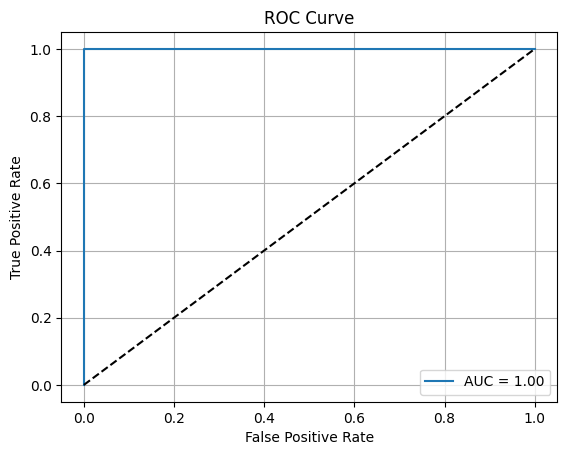

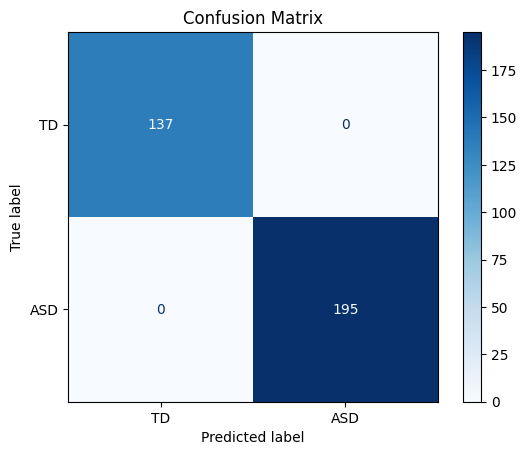

AUC: 1.00
Accuracy : 1.00
Precision: 1.00
Recall   : 1.00
F1 Score : 1.00
True Positive : 195
True Negative : 137
False Positive Rate: 0.00
False Negative Rate: 0.00


In [169]:
# Predicting on train data
y_pred_train = pipeline.predict(X_train)
y_prob_train = pipeline.predict_proba(X_train)[:, 0] # TD:0, ASD:1
auc_score_train, accuracy_train, precision_train, recall_train, f1_train, tn_train, tp_train, fn_train, fp_train, fpr_train, fnr_train = model_performance(y_train, y_pred_train, y_prob_train)

Label encoding: TD -> 0, ASD -> 1


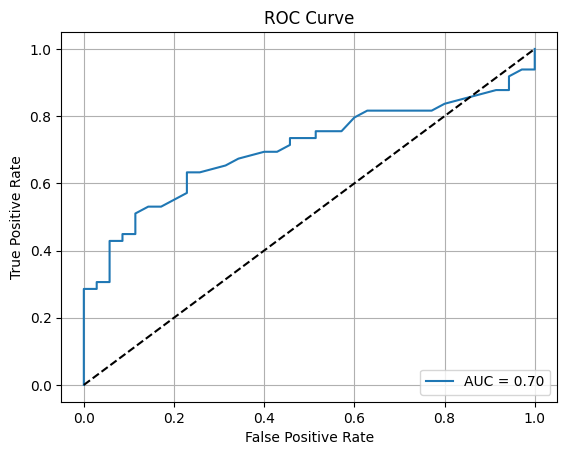

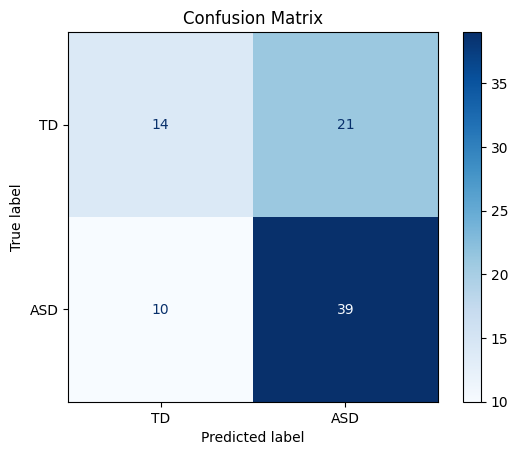

AUC: 0.70
Accuracy : 0.63
Precision: 0.65
Recall   : 0.80
F1 Score : 0.72
True Positive : 39
True Negative : 14
False Positive Rate: 0.60
False Negative Rate: 0.20


In [170]:
#Predicting on test data
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 0] # TD:0, ASD:1
auc_score, accuracy, precision, recall, f1, tn, tp, fn, fp, fpr, fnr = model_performance(y_test, y_pred, y_prob)

In [171]:
# Exporting the model
#from joblib import dump
#dump(pipeline, 'model_pipeline_name.joblib')

In [172]:
# Load the model
#from joblib import load
#import pandas as pd
## Load the trained pipeline
#pipeline = load('model_pipeline_name.joblib')
## Load or create external data (must match input format of training)
#external_data = pd.read_csv('external_data.csv')
## Use the pipeline to predict
#predictions = pipeline.predict(external_data)

In [173]:
# Creating dataframe
import pandas as pd

preprocessing = []
for step in pipeline:
    #print(step)
    preprocessing.append(step)

#parameters_df = pd.DataFrame()
parameters_df = pd.read_excel("parameters-performance.xlsx")
try: parameters_df = parameters_df.drop("Unnamed: 0", axis=1)
except: pass

parameters = {
    "file": [file],
    "preprocessing": [preprocessing],
    "auc_score": auc_score, 
    "accuracy": accuracy, 
    "precision": precision, 
    "recall": recall, 
    "f1": f1, 
    "tn": tn, 
    "tp": tp, 
    "fn": fn, 
    "fp": fp, 
    "fpr": fpr, 
    "fnr": fnr,
    "auc_score_train": auc_score_train, 
    "accuracy_train": accuracy_train, 
    "precision_train": precision_train, 
    "recall_train": recall_train, 
    "f1_train": f1_train, 
    "tn_train": tn_train, 
    "tp_train": tp_train, 
    "fn_train": fn_train, 
    "fp_train": fp_train, 
    "fpr_train": fpr_train, 
    "fnr_train": fnr_train
}

#parameters_df = pd.DataFrame(parameters)

new_row = pd.DataFrame(parameters)
parameters_df = pd.concat([parameters_df, new_row], ignore_index=True)

parameters_df.to_excel("parameters-performance.xlsx")
display(parameters_df)

file  \
0               pathways.csv   
1               pathways.csv   
2               pathways.csv   
3               pathways.csv   
4               pathways.csv   
5               pathways.csv   
6               pathways.csv   
7               pathways.csv   
8               pathways.csv   
9               pathways.csv   
10              pathways.csv   
11              pathways.csv   
12  pathways-PRJNA895487.csv   
13  pathways-PRJNA895487.csv   
14  pathways-PRJNA895487.csv   
15  pathways-PRJNA516054.csv   
16  pathways-PRJNA451479.csv   
17  pathways-PRJNA895487.csv   
18  pathways-PRJNA516054.csv   
19              pathways.csv   
20              pathways.csv   
21              pathways.csv   
22              pathways.csv   
23              pathways.csv   
24                 genes.csv   
25              full-wgs.csv   
26               enzymes.csv   
27                  taxonomy   
28           metabolites-jan   
29                  taxonomy   
30                  pathways   
31                  full-wgs   
32                  taxonomy   
33                     genes   
34                   enzymes   

                                        preprocessing  auc_score  accuracy  \
0   [KNNImputer(weights='distance'), VarianceThres...   0.664431  0.595238   
1   [KNNImputer(weights='distance'), VarianceThres...   0.681633  0.607143   
2   [KNNImputer(weights='distance'), VarianceThres...   0.685714  0.583333   
3   [KNNImputer(weights='distance'), VarianceThres...   0.664140  0.571429   
4   [KNNImputer(weights='distance'), VarianceThres...   0.675219  0.583333   
5   [KNNImputer(weights='distance'), VarianceThres...   0.673469  0.595238   
6   [KNNImputer(weights='distance'), VarianceThres...   0.668222  0.571429   
7   [KNNImputer(weights='distance'), VarianceThres...   0.548397  0.559524   
8   [KNNImputer(weights='distance'), VarianceThres...   0.671720  0.595238   
9   [KNNImputer(weights='distance'), VarianceThres...   0.671137  0.619048   
10  [KNNImputer(weights='distance'), VarianceThres...   0.666472  0.583333   
11  [KNNImputer(weights='distance'), VarianceThres...   0.652478  0.571429   
12  [KNNImputer(weights='distance'), VarianceThres...   0.487179  0.500000   
13  [KNNImputer(weights='distance'), VarianceThres...   0.446154  0.428571   
14  [KNNImputer(weights='distance'), VarianceThres...   0.482051  0.500000   
15  [KNNImputer(weights='distance'), VarianceThres...   0.875000  0.785714   
16  [KNNImputer(weights='distance'), VarianceThres...   0.550000  0.636364   
17  [KNNImputer(weights='distance'), VarianceThres...   0.507692  0.464286   
18  [KNNImputer(weights='distance'), VarianceThres...   0.862500  0.857143   
19  [KNNImputer(weights='distance'), VarianceThres...   0.706706  0.607143   
20  [KNNImputer(weights='distance'), VarianceThres...   0.659767  0.630952   
21  [KNNImputer(weights='distance'), VarianceThres...   0.662391  0.535714   
22  [KNNImputer(weights='distance'), VarianceThres...   0.670554  0.571429   
23  [KNNImputer(weights='distance'), VarianceThres...   0.670262  0.583333   
24  [KNNImputer(weights='distance'), VarianceThres...   0.722741  0.654762   
25  [KNNImputer(weights='distance'), VarianceThres...   0.679592  0.595238   
26  [KNNImputer(weights='distance'), VarianceThres...   0.712245  0.642857   
27  [KNNImputer(weights='distance'), VarianceThres...   0.718367  0.630952   
28  [KNNImputer(weights='distance'), VarianceThres...   0.485833  0.510204   
29  [KNNImputer(weights='distance'), VarianceThres...   0.693878  0.607143   
30  [KNNImputer(weights='distance'), VarianceThres...   0.653353  0.571429   
31  [KNNImputer(weights='distance'), VarianceThres...   0.714577  0.630952   
32  [KNNImputer(weights='distance'), VarianceThres...   0.721866  0.619048   
33  [KNNImputer(weights='distance'), VarianceThres...   0.709038  0.630952   
34  [KNNImputer(weights='distance'), VarianceThres...   0.703207  0.630952   

    precision    recall        f1  tn  tp  fn  ...  accuracy_t